In [2]:
import numpy as np
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")


In [3]:
data_path = r"C:\Users\BatuhanÇağlar\Desktop\470\proje\data\soccer\database.sqlite"
conn = sqlite3.connect(data_path)

df_match = pd.read_sql("SELECT * FROM Match", conn)
df_team = pd.read_sql("SELECT * FROM Team", conn)
df_team_attr = pd.read_sql("SELECT * FROM Team_Attributes", conn)
df_player = pd.read_sql("SELECT * FROM Player", conn)
df_player_attr = pd.read_sql("SELECT * FROM Player_Attributes", conn)
df_country = pd.read_sql("SELECT * FROM Country", conn)
df_league = pd.read_sql("SELECT * FROM League", conn)


In [4]:
bet_cols = [
    'B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA',
    'LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA',
    'VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA'
]
drop_cols = ['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
all_drop = [c for c in bet_cols + drop_cols if c in df_match.columns]
df = df_match.drop(columns=all_drop)

missing_rate = df.isnull().mean()
THRESHOLD = 0.3
too_missing_cols = missing_rate[missing_rate > THRESHOLD].index.tolist()
df = df.drop(columns=too_missing_cols)

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['match_month'] = df['date'].dt.month
df['match_week'] = df['date'].dt.isocalendar().week.astype(int)
df['season_num'] = df['season'].astype('category').cat.codes


In [6]:
def match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1
    elif row['home_team_goal'] < row['away_team_goal']:
        return 2
    else:
        return 0
df['match_result'] = df.apply(match_result, axis=1)


In [7]:
team_attr = df_team_attr.copy()
team_attr['date'] = pd.to_datetime(team_attr['date'])

def get_team_attr(team_id, match_date, col):
    ta = team_attr[team_attr['team_api_id'] == team_id]
    ta = ta[ta['date'] <= match_date]
    if ta.empty: return np.nan
    else: return ta.sort_values('date', ascending=False).iloc[0][col]

for side, team_col in [('home', 'home_team_api_id'), ('away', 'away_team_api_id')]:
    for col in ['buildUpPlayPassing', 'buildUpPlaySpeed', 'defencePressure', 'defenceAggression',
                'defenceTeamWidth', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting']:
        featname = f"{side}_{col}"
        df[featname] = df.apply(lambda r: get_team_attr(r[team_col], pd.to_datetime(r['date']), col), axis=1)

for col in ['buildUpPlayPassing', 'buildUpPlaySpeed', 'defencePressure', 'defenceAggression',
            'defenceTeamWidth', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting']:
    df[f"rating_diff_{col}"] = df[f"home_{col}"] - df[f"away_{col}"]


In [8]:
def calc_elo(df, k=40):
    elo_dict = {}
    home_elos, away_elos = [], []
    for idx, row in df.sort_values('date').iterrows():
        h, a = row['home_team_api_id'], row['away_team_api_id']
        elo_h = elo_dict.get(h, 1500)
        elo_a = elo_dict.get(a, 1500)
        home_elos.append(elo_h)
        away_elos.append(elo_a)
        if row['home_team_goal'] > row['away_team_goal']: r, s = 1, 0
        elif row['home_team_goal'] < row['away_team_goal']: r, s = 0, 1
        else: r, s = 0.5, 0.5
        exp_h = 1/(1+10**((elo_a-elo_h)/400))
        exp_a = 1/(1+10**((elo_h-elo_a)/400))
        elo_dict[h] = elo_h + k*(r-exp_h)
        elo_dict[a] = elo_a + k*(s-exp_a)
    df['elo_home'] = home_elos
    df['elo_away'] = away_elos
    df['elo_diff'] = df['elo_home'] - df['elo_away']
    return df

df = calc_elo(df, k=40)


In [9]:
player_attr = df_player_attr.copy()
player_attr['date'] = pd.to_datetime(player_attr['date'])

def get_player_rating(player_id, match_date):
    pa = player_attr[player_attr['player_api_id'] == player_id]
    pa = pa[pa['date'] <= match_date]
    if pa.empty: return np.nan
    else: return pa.sort_values('date', ascending=False).iloc[0]['overall_rating']

def squad_ratings(row, side):
    ratings = []
    match_date = pd.to_datetime(row['date'])
    for i in range(1, 12):
        player_col = f'{side}_player_{i}'
        player_id = row[player_col]
        if player_id is not None and player_id > 0:
            rating = get_player_rating(player_id, match_date)
        else:
            rating = np.nan
        ratings.append(rating)
    return ratings

home_ratings = df.apply(lambda r: squad_ratings(r, 'home'), axis=1)
away_ratings = df.apply(lambda r: squad_ratings(r, 'away'), axis=1)
df['home11_mean_rating'] = [np.nanmean(x) for x in home_ratings]
df['away11_mean_rating'] = [np.nanmean(x) for x in away_ratings]
df['home11_min_rating'] = [np.nanmin(x) for x in home_ratings]
df['away11_min_rating'] = [np.nanmin(x) for x in away_ratings]
df['home11_max_rating'] = [np.nanmax(x) for x in home_ratings]
df['away11_max_rating'] = [np.nanmax(x) for x in away_ratings]
df['home11_std_rating'] = [np.nanstd(x) for x in home_ratings]
df['away11_std_rating'] = [np.nanstd(x) for x in away_ratings]
df['home11_count70'] = [np.sum(np.array(x) >= 70) for x in home_ratings]
df['away11_count70'] = [np.sum(np.array(x) >= 70) for x in away_ratings]
df['home11_count80'] = [np.sum(np.array(x) >= 80) for x in home_ratings]
df['away11_count80'] = [np.sum(np.array(x) >= 80) for x in away_ratings]
df['home11_count_nan'] = [np.sum(np.isnan(x)) for x in home_ratings]
df['away11_count_nan'] = [np.sum(np.isnan(x)) for x in away_ratings]


In [10]:
df['mean11_rating_diff'] = df['home11_mean_rating'] - df['away11_mean_rating']
df['min11_rating_diff'] = df['home11_min_rating'] - df['away11_min_rating']
df['count80_rating_diff'] = df['home11_count80'] - df['away11_count80']



In [11]:
def rolling_form_features(df, N_list=[5,10]):
    for N in N_list:
        for side, team_col, goal_col, opp_goal_col in [
            ('home', 'home_team_api_id', 'home_team_goal', 'away_team_goal'),
            ('away', 'away_team_api_id', 'away_team_goal', 'home_team_goal')
        ]:
            pts, goals, conceded, wins, draws, losses, avgs, clean_sheets, non_scored = [], [], [], [], [], [], [], [], []
            for i, row in df.iterrows():
                team_id = row[team_col]
                date = row['date']
                prev = df[((df['home_team_api_id']==team_id) | (df['away_team_api_id']==team_id)) & (df['date'] < date)]
                prev = prev.sort_values('date', ascending=False).head(N)
                if prev.empty:
                    pts.append(np.nan); goals.append(np.nan); conceded.append(np.nan)
                    wins.append(np.nan); draws.append(np.nan); losses.append(np.nan)
                    avgs.append(np.nan); clean_sheets.append(np.nan); non_scored.append(np.nan)
                else:
                    p = g = c = w = d = l = avg = cs = ns = 0
                    for _, r in prev.iterrows():
                        if r['home_team_api_id'] == team_id:
                            gf, ga = r['home_team_goal'], r['away_team_goal']
                        else:
                            gf, ga = r['away_team_goal'], r['home_team_goal']
                        g += gf; c += ga
                        if gf > ga: w += 1; p += 3
                        elif gf == ga: d += 1; p += 1
                        else: l += 1
                        if gf == 0: ns += 1
                        if ga == 0: cs += 1
                    n = len(prev)
                    pts.append(p/n)
                    goals.append(g/n)
                    conceded.append(c/n)
                    wins.append(w/n)
                    draws.append(d/n)
                    losses.append(l/n)
                    avgs.append((g-c)/n)
                    clean_sheets.append(cs/n)
                    non_scored.append(ns/n)
            df[f'{side}_last{N}_pts_avg'] = pts
            df[f'{side}_last{N}_goal_avg'] = goals
            df[f'{side}_last{N}_concede_avg'] = conceded
            df[f'{side}_last{N}_winrate'] = wins
            df[f'{side}_last{N}_drawrate'] = draws
            df[f'{side}_last{N}_loserate'] = losses
            df[f'{side}_last{N}_goal_diff_avg'] = avgs
            df[f'{side}_last{N}_clean_sheet_rate'] = clean_sheets
            df[f'{side}_last{N}_non_scored_rate'] = non_scored
    return df

df = rolling_form_features(df, N_list=[5,10])


In [12]:
def season_form_features(df):
    for side, team_col, goal_col, opp_goal_col in [
        ('home', 'home_team_api_id', 'home_team_goal', 'away_team_goal'),
        ('away', 'away_team_api_id', 'away_team_goal', 'home_team_goal')
    ]:
        pts_avg, goals_avg, concede_avg, winrate, drawrate, loserate = [], [], [], [], [], []
        for i, row in df.iterrows():
            team_id = row[team_col]
            date = row['date']
            season = row['season']
            prev = df[((df['home_team_api_id']==team_id) | (df['away_team_api_id']==team_id)) & 
                      (df['date'] < date) & (df['season']==season)]
            if prev.empty:
                pts_avg.append(np.nan); goals_avg.append(np.nan); concede_avg.append(np.nan)
                winrate.append(np.nan); drawrate.append(np.nan); loserate.append(np.nan)
            else:
                p = g = c = w = d = l = 0
                for _, r in prev.iterrows():
                    if r['home_team_api_id'] == team_id:
                        gf, ga = r['home_team_goal'], r['away_team_goal']
                    else:
                        gf, ga = r['away_team_goal'], r['home_team_goal']
                    g += gf; c += ga
                    if gf > ga: w += 1; p += 3
                    elif gf == ga: d += 1; p += 1
                    else: l += 1
                n = len(prev)
                pts_avg.append(p/n)
                goals_avg.append(g/n)
                concede_avg.append(c/n)
                winrate.append(w/n)
                drawrate.append(d/n)
                loserate.append(l/n)
        df[f'{side}_season_pts_avg'] = pts_avg
        df[f'{side}_season_goal_avg'] = goals_avg
        df[f'{side}_season_concede_avg'] = concede_avg
        df[f'{side}_season_winrate'] = winrate
        df[f'{side}_season_drawrate'] = drawrate
        df[f'{side}_season_loserate'] = loserate
    return df

df = season_form_features(df)


In [13]:
def home_away_form_features(df, N_list=[5,10]):
    for N in N_list:
        for side, team_col, home_or_away in [('home', 'home_team_api_id', True), ('away', 'away_team_api_id', False)]:
            winrate, goals, conceded, points = [], [], [], []
            for i, row in df.iterrows():
                team_id = row[team_col]
                date = row['date']
                if home_or_away:
                    prev = df[(df['home_team_api_id']==team_id) & (df['date'] < date)].sort_values('date', ascending=False).head(N)
                    gf_col, ga_col = 'home_team_goal', 'away_team_goal'
                else:
                    prev = df[(df['away_team_api_id']==team_id) & (df['date'] < date)].sort_values('date', ascending=False).head(N)
                    gf_col, ga_col = 'away_team_goal', 'home_team_goal'
                if prev.empty:
                    winrate.append(np.nan); goals.append(np.nan); conceded.append(np.nan); points.append(np.nan)
                else:
                    w = g = c = p = 0
                    for _, r in prev.iterrows():
                        gf, ga = r[gf_col], r[ga_col]
                        g += gf; c += ga
                        if gf > ga: w += 1; p += 3
                        elif gf == ga: p += 1
                    n = len(prev)
                    winrate.append(w/n)
                    goals.append(g/n)
                    conceded.append(c/n)
                    points.append(p/n)
            df[f'{side}_last{N}_{side}_only_winrate'] = winrate
            df[f'{side}_last{N}_{side}_only_goal_avg'] = goals
            df[f'{side}_last{N}_{side}_only_concede_avg'] = conceded
            df[f'{side}_last{N}_{side}_only_pts_avg'] = points
    return df

df = home_away_form_features(df, N_list=[5,10])


In [14]:
def streak_features(df, N_list=[5,10]):
    for N in N_list:
        for side, team_col, goal_col, opp_goal_col in [
            ('home', 'home_team_api_id', 'home_team_goal', 'away_team_goal'),
            ('away', 'away_team_api_id', 'away_team_goal', 'home_team_goal')
        ]:
            win_streak, unbeaten_streak = [], []
            for i, row in df.iterrows():
                team_id = row[team_col]
                date = row['date']
                prev = df[((df['home_team_api_id']==team_id) | (df['away_team_api_id']==team_id)) & (df['date'] < date)]
                prev = prev.sort_values('date', ascending=False).head(N)
                win = 0
                for _, r in prev.iterrows():
                    if r['home_team_api_id'] == team_id:
                        gf, ga = r['home_team_goal'], r['away_team_goal']
                    else:
                        gf, ga = r['away_team_goal'], r['home_team_goal']
                    if gf > ga: win += 1
                    else: break
                win_streak.append(win)
                unbeaten = 0
                for _, r in prev.iterrows():
                    if r['home_team_api_id'] == team_id:
                        gf, ga = r['home_team_goal'], r['away_team_goal']
                    else:
                        gf, ga = r['away_team_goal'], r['home_team_goal']
                    if gf >= ga: unbeaten += 1
                    else: break
                unbeaten_streak.append(unbeaten)
            df[f'{side}_last{N}_win_streak'] = win_streak
            df[f'{side}_last{N}_unbeaten_streak'] = unbeaten_streak
    return df

df = streak_features(df, N_list=[5,10])


In [15]:
def opponent_avg_elo(df, N_list=[5,10]):
    if 'elo_home' not in df.columns:
        print("ELO rating feature'ı yok, önce elo feature'ı ekle!")
        return df
    for N in N_list:
        for side, team_col, opp_team_col in [
            ('home', 'home_team_api_id', 'away_team_api_id'),
            ('away', 'away_team_api_id', 'home_team_api_id')
        ]:
            opp_elo = []
            for i, row in df.iterrows():
                team_id = row[team_col]
                date = row['date']
                prev = df[((df['home_team_api_id']==team_id) | (df['away_team_api_id']==team_id)) & (df['date'] < date)]
                prev = prev.sort_values('date', ascending=False).head(N)
                if prev.empty:
                    opp_elo.append(np.nan)
                else:
                    elos = []
                    for _, r in prev.iterrows():
                        if r['home_team_api_id'] == team_id:
                            elos.append(r['elo_away'])
                        else:
                            elos.append(r['elo_home'])
                    opp_elo.append(np.mean(elos))
            df[f'{side}_last{N}_opp_elo_avg'] = opp_elo
    return df

df = opponent_avg_elo(df, N_list=[5,10])


In [16]:
def first_goal_rate(df, N_list=[5,10]):
    for N in N_list:
        for side, team_col in [('home', 'home_team_api_id'), ('away', 'away_team_api_id')]:
            fg_rate = []
            for i, row in df.iterrows():
                team_id = row[team_col]
                date = row['date']
                prev = df[((df['home_team_api_id']==team_id) | (df['away_team_api_id']==team_id)) & (df['date'] < date)]
                prev = prev.sort_values('date', ascending=False).head(N)
                if prev.empty:
                    fg_rate.append(np.nan)
                else:
                    fg = 0
                    for _, r in prev.iterrows():
                        if r['home_team_goal'] == r['away_team_goal']:
                            continue
                        if r['home_team_api_id'] == team_id:
                            first = 1 if r['home_team_goal'] > 0 and r['away_team_goal'] == 0 else 0
                        else:
                            first = 1 if r['away_team_goal'] > 0 and r['home_team_goal'] == 0 else 0
                        fg += first
                    fg_rate.append(fg / len(prev))
            df[f'{side}_last{N}_first_goal_rate'] = fg_rate
    return df

df = first_goal_rate(df, N_list=[5,10])


In [17]:
def lineup_stability(df, N=1):
    for side in ['home', 'away']:
        lineup_same_count = []
        for i, row in df.iterrows():
            team_id = row[f'{side}_team_api_id'] if f'{side}_team_api_id' in row else row[f'{side}_team_api_id']
            date = row['date']
            prev = df[(df[f'{side}_team_api_id']==team_id) & (df['date'] < date)].sort_values('date', ascending=False).head(N)
            if prev.empty:
                lineup_same_count.append(np.nan)
            else:
                prev_row = prev.iloc[0]
                now_lineup = [row[f'{side}_player_{k}'] for k in range(1,12)]
                prev_lineup = [prev_row[f'{side}_player_{k}'] for k in range(1,12)]
                same = sum([a==b and a>0 for a,b in zip(now_lineup, prev_lineup)])
                lineup_same_count.append(same)
        df[f'{side}_lineup_same_last'] = lineup_same_count
    return df

df = lineup_stability(df, N=1)


In [18]:
for N in [5, 10]:
    df[f'form_pts_avg_diff_{N}'] = df[f'home_last{N}_pts_avg'] - df[f'away_last{N}_pts_avg']
    df[f'form_goal_avg_diff_{N}'] = df[f'home_last{N}_goal_avg'] - df[f'away_last{N}_goal_avg']
    df[f'form_concede_avg_diff_{N}'] = df[f'home_last{N}_concede_avg'] - df[f'away_last{N}_concede_avg']
    df[f'form_winrate_diff_{N}'] = df[f'home_last{N}_winrate'] - df[f'away_last{N}_winrate']
    df[f'form_goal_diff_avg_diff_{N}'] = df[f'home_last{N}_goal_diff_avg'] - df[f'away_last{N}_goal_diff_avg']
    df[f'clean_sheet_rate_diff_{N}'] = df[f'home_last{N}_clean_sheet_rate'] - df[f'away_last{N}_clean_sheet_rate']
    df[f'non_scored_rate_diff_{N}'] = df[f'home_last{N}_non_scored_rate'] - df[f'away_last{N}_non_scored_rate']
    df[f'opp_elo_avg_diff_{N}'] = df[f'home_last{N}_opp_elo_avg'] - df[f'away_last{N}_opp_elo_avg']


In [19]:
for col in df.columns:
    if df[col].isnull().any():
        if np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])


In [20]:
# Drop ve dummy işlemleri
drop_cols = [
    'id', 'date', 'season', 'stage', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
    'home_team_goal', 'away_team_goal', 'match_result'
]
drop_cols += [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
drop_cols += [f'home_player_X{i}' for i in range(1, 12)] + [f'away_player_X{i}' for i in range(1, 12)]
drop_cols += [f'home_player_Y{i}' for i in range(1, 12)] + [f'away_player_Y{i}' for i in range(1, 12)]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['match_result']

cat_cols = [col for col in X.columns if X[col].dtype == 'O']
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [27]:
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

scaler = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\soccer_scaler.pkl")
X_test_scaled = scaler.transform(X_test)

model_rf = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\soccer_rf.pkl")
model_xgb = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\soccer_xgb.pkl")
model_mlp = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\soccer_mlp.pkl")



Random Forest Test Sonuçları:
Accuracy: 0.5144341801385681
F1-score (weighted): 0.4396195043517959
Confusion matrix:
 [[  35  993  291]
 [  36 2027  321]
 [  43  839  611]]
              precision    recall  f1-score   support

           0       0.31      0.03      0.05      1319
           1       0.53      0.85      0.65      2384
           2       0.50      0.41      0.45      1493

    accuracy                           0.51      5196
   macro avg       0.44      0.43      0.38      5196
weighted avg       0.46      0.51      0.44      5196



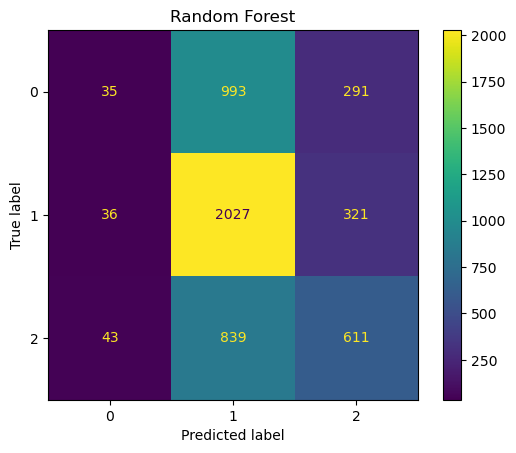


XGBoost Test Sonuçları:
Accuracy: 0.5144341801385681
F1-score (weighted): 0.4331794930672447
Confusion matrix:
 [[  10 1005  304]
 [  24 2020  340]
 [   8  842  643]]
              precision    recall  f1-score   support

           0       0.24      0.01      0.01      1319
           1       0.52      0.85      0.65      2384
           2       0.50      0.43      0.46      1493

    accuracy                           0.51      5196
   macro avg       0.42      0.43      0.37      5196
weighted avg       0.44      0.51      0.43      5196



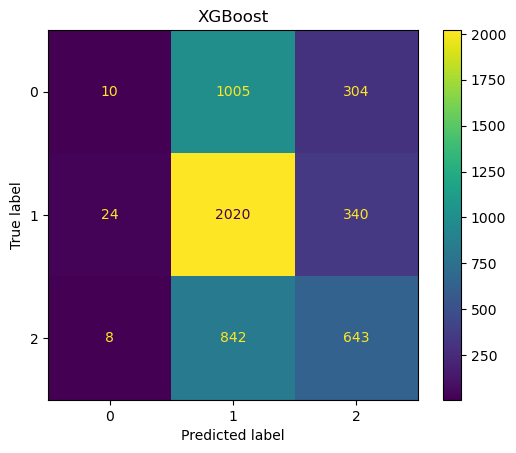


MLP Test Sonuçları:
Accuracy: 0.4736335642802155
F1-score (weighted): 0.4557149153701678
Confusion matrix:
 [[ 237  752  330]
 [ 380 1578  426]
 [ 242  605  646]]
              precision    recall  f1-score   support

           0       0.28      0.18      0.22      1319
           1       0.54      0.66      0.59      2384
           2       0.46      0.43      0.45      1493

    accuracy                           0.47      5196
   macro avg       0.42      0.42      0.42      5196
weighted avg       0.45      0.47      0.46      5196



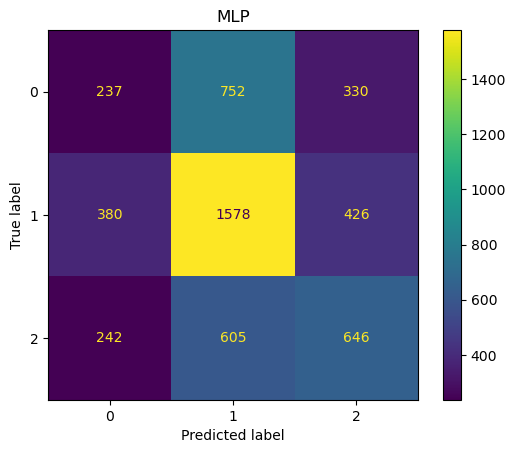

In [28]:
models = {
    "Random Forest": model_rf,
    "XGBoost": model_xgb,
    "MLP": model_mlp
}

for name, model in models.items():
    print(f"\n{name} Test Sonuçları:")
    y_pred = model.predict(X_test_scaled)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(name)
    plt.show()


In [29]:
results = pd.DataFrame({
    "y_true": y_test,
    "rf_pred": model_rf.predict(X_test_scaled),
    "xgb_pred": model_xgb.predict(X_test_scaled),
    "mlp_pred": model_mlp.predict(X_test_scaled)
})
results.to_csv("soccer_test_predictions.csv", index=False)


Random Forest Modeli beraberlikleri çok iyi tahmin ediyor (class 1’in recall’i %85) ama ev sahibi galibiyetlerini neredeyse hiç tahmin edemiyor.
Özellikle sınıf 0 (ev sahibi galibiyet) neredeyse tamamen class 1 olarak tahmin edilmiş. Bu, modelin ciddi şekilde sınıf dengesizliği problemi yaşadığını gösteriyor.
Modelin genel başarısı tesadüfi (random guess) seviyesinde ve uygulanabilir değil.MLP modeli de Random Forest gibi beraberlikleri diğer sınıflara göre daha iyi tahmin ediyor ama diğer sınıflarda başarı düşük.XGBoost, neredeyse sadece “beraberlik” (class 1) tahmini yapıyor. “Ev sahibi galibiyet” sınıfını tamamen ihmal ediyor (sadece 10 doğru!), “deplasman galibiyeti” ise orta düzeyde.